<a href="https://www.kaggle.com/code/pronoydeb/convnext-model?scriptVersionId=260357275" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <span style="color:coral"> <center> ConvNeXt with tensorflow</center> </span>

# <span >Notebook Overview</span>

* In this notebook I have implemented `ConvNext tiny` model from the research paper titled as [A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545) using tensorflow.

* The code in this notebook is reusable and can be reused with any dataset of your choice.

* In this notebook I will train `ConvNext tiny` model from scratch on CIFAR-10 dataset.


In [42]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

# <span style="color:coral">Loading Data</span>

In [43]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to dataset
data_path = "/kaggle/input/severity-based-rice-disease-final/severity-based-rice-disease-final"

def safe_label(name: str):
    """Convert folder name into safe label"""
    return name.strip().replace(" ", "_").replace("-", "_")

def load_leaf_disease_dataset(dataset_path, img_size=(128, 128)):
    def load_subset(subset):
        images = []
        labels = []
        subset_path = os.path.join(dataset_path, subset)

        for disease_name in os.listdir(subset_path):
            disease_path = os.path.join(subset_path, disease_name)
            if os.path.isdir(disease_path):
                safe_name = safe_label(disease_name)  # <-- use safe name here
                for img_file in os.listdir(disease_path):
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(disease_path, img_file)
                        try:
                            img = Image.open(img_path).convert("RGB")
                            img = img.resize(img_size)
                            images.append(np.array(img))
                            labels.append(safe_name)   # <-- append safe label
                        except Exception as e:
                            print(f"Error loading {img_path}: {e}")
        return np.array(images), np.array(labels)

    # Load train, validation, and test separately
    x_train, y_train = load_subset("train")
    x_val, y_val = load_subset("validation")
    x_test, y_test = load_subset("test")

    # Encode labels
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_val = le.transform(y_val)
    y_test = le.transform(y_test)

    return (x_train, y_train), (x_val, y_val), (x_test, y_test), le.classes_

# Load data
(x_train, y_train), (x_val, y_val), (x_test, y_test), class_names = load_leaf_disease_dataset(data_path)

# Normalize images (0–1)
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

print(f"Classes detected: {class_names}")
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

# -------------------------
# Data Augmentation (only for training)
# -------------------------
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Fit generator to training data
datagen.fit(x_train)

train_dir = data_path + "/train"
val_dir = data_path + "/validation"
test_dir = data_path + "/test"

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    color_mode='rgb'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    color_mode='rgb'
)

test_data = datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=False
)

test_generator = (x_test, y_test)  # no augmentation for test

Classes detected: ['Healthy' 'Mild_Bacterial_blight' 'Mild_Blast' 'Mild_Brownspot'
 'Mild_Tungro' 'Severe_Bacterial_blight' 'Severe_Blast' 'Severe_Brownspot'
 'Severe_Tungro']
x_train: (2402, 128, 128, 3), y_train: (2402,)
x_val: (424, 128, 128, 3), y_val: (424,)
x_test: (180, 128, 128, 3), y_test: (180,)
Found 2402 images belonging to 9 classes.
Found 424 images belonging to 9 classes.
Found 180 images belonging to 9 classes.


I will be using `tf.data` api which helps to build flexible and efficient input pipeline.
​
td.data allows us to do various tasks in memory efficient way such as :
​
* `map()` - maps a predefined function to dataset
* `shuffle()` - randomly shuffles the elements of a target 
* `batch()` - turns dataset into batches 
* `prefetch()` - prepares subsequent batches of data while other batches of data are being computed

In [44]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE=16
# convert images to float32 format and convert labels to int32
def preprocess (image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.cast(label, tf.int32)
    return image, label

#Peform augmentations on training data
def augmentation(image,label):
    image = tf.image.resize_with_crop_or_pad(image, 40, 40) # Add 8 pixels of padding
    image = tf.image.random_crop(image, size=[32, 32, 3]) # Random crop back to 32x32
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0., 1.)
    return image, label


train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#applying transformations 
train_data = train_data.shuffle(1024) # shuffle the images
train_data = train_data.map(preprocess, num_parallel_calls=AUTO)# mapping our preprocess function to train_data 
train_data = train_data.map(augmentation, num_parallel_calls=AUTO)# mapping our augmentation funtion to train_data
train_data = train_data.batch(BATCH_SIZE) #Converting train_data to batches
train_data = train_data.prefetch(AUTO) # using prefetch which prepares subsequent batches of data while other batches are being computed.

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
#applying transformations 
test_data = test_data.map(preprocess, num_parallel_calls=AUTO) # mapping our preprocess function test_data 
test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(AUTO) # using prefetch which prepares subsequent batches of data while other batches are being computed.

# <center>ConvNeXt Block</center>

For implementing `ConvNeXt` block authors take inspiration from the `ResNext` architecture which use [grouped convolutions](https://paperswithcode.com/method/grouped-convolution#:~:text=A%20Grouped%20Convolution%20uses%20a,level%20and%20high%20level%20features.), for `ConvNeXt` block authors utlize the combination of [depthwise convolutions](https://paperswithcode.com/method/depthwise-convolution) and 1x1 [point-wise convolutions](https://paperswithcode.com/method/pointwise-convolution). Depthwise convolutions reduce the number of parameters and computation used in convolutional operations while increasing representational efficiency. Pointwise convolutions is a 1x1 convolution which projects the channels output by the depthwise convolution onto a new channel space
 
In this paper authors use a slightly modified [inverted bottle-neck](https://paperswithcode.com/method/inverted-residual-block) design given by:

1. A depthwise convolution, authors found out that `7x7 size` depthwise convolution gives better performance than that of other sizes. followed by a layer norm normalization layer as used in transformer architectures.

2. `Layer normalization` is used after the depthwise convolution instead of the Batch Normalization. As opposed to ResNet Block architecture ConvNeXt block only uses `layer norm` once in a residual block. 

> `Note:` In batchnorm, the mean and variance used for normalization are calculated across all elements in a batch, for each feature independently while in layernorm, they are calculated across the feature dimension, for each element and instance independently. 

3. A 1x1 `pointwise convolution` is used after LN.

4. A [GELU](https://paperswithcode.com/method/gelu) activation function is used after 1x1 pointwise convolutional layer. As opposed to multiple ReLU activations in ResNet residual block, ConvNext uses GELU activation function only once in a residual block.

5. Another 1x1 `pointwise convolution` is used.

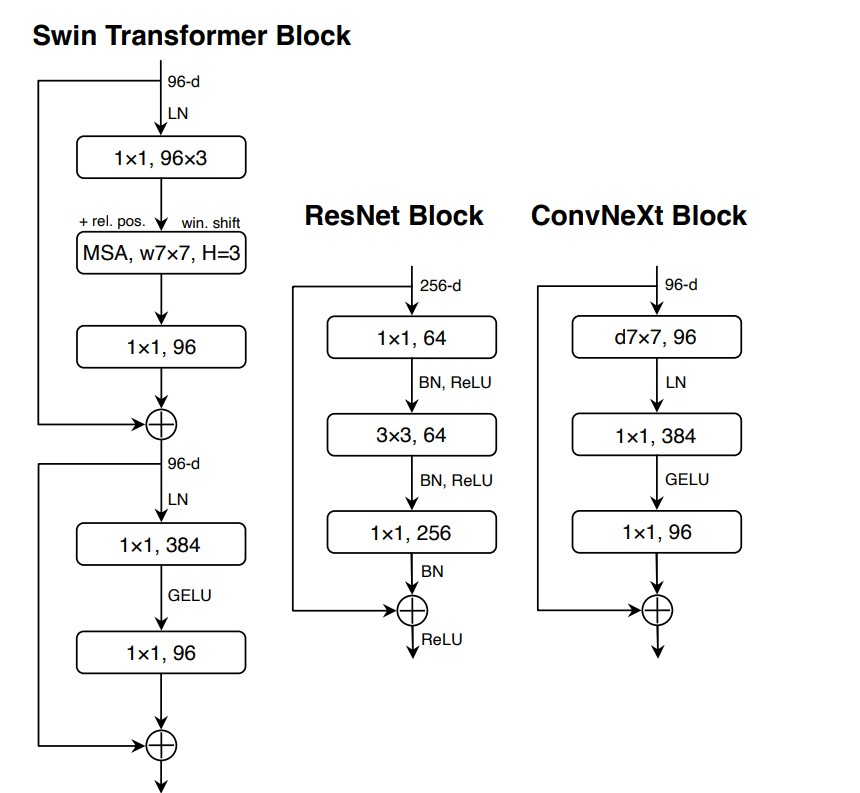

> Image source [A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545) 

In [45]:
class ConvNext_Block(tf.keras.Model):
    
    """
    Implementing the ConvNeXt block for 
    
    Args:
        dim: No of input channels
        drop_path: stotchastic depth rate 
        layer_scale_init_value=1e-6
    
    Returns:
        A conv block
    """
    
    def __init__(self, dim, drop_path=0.0, layer_scale_init_value=1e-6, **kwargs):
        super(ConvNext_Block, self).__init__(**kwargs)
        
        self.depthwise_convolution = layers.Conv2D(dim, kernel_size=7, padding="same", groups=dim )
        self.layer_normalization = layers.LayerNormalization(epsilon=1e-6)
        self.pointwise_convolution_1 = layers.Dense(4 * dim)
        self.GELU = layers.Activation("gelu")
        self.pointwise_convolution_2 = layers.Dense(dim)
        self.gamma = tf.Variable(layer_scale_init_value * tf.ones((dim,)))
        if drop_path>0.0:
            self.drop_path=(tfa.layers.StochasticDepth(drop_path))
        else:
            self.drop_path=layers.Activation("linear")
        

    def call(self, inputs):
        x = inputs
        x = self.depthwise_convolution(x)
        x = self.layer_normalization(x)
        x = self.pointwise_convolution_1(x)
        x = self.GELU(x)
        x = self.pointwise_convolution_2(x)
        x = self.gamma * x

        return inputs + self.drop_path(x)


# Patchify Stem 

For processing the input images, ConvNeXt utilizes patchify strategy of transformers by 4x4 convolutional layer with stride of 4 i.e it will have non overlapping patches.

In [46]:
def patchify_stem(dims):
    """
    Implements the stem block of ConvNeXt
    
    Args:
        Dims: List of feature dimensions at each stage.
    
    Returns:
        feature maps after patchify operation
    """
    stem = keras.Sequential(
        [layers.Conv2D(dims[0], kernel_size=4, strides=4),
        layers.LayerNormalization(epsilon=1e-6)],
        )
    return stem

# Spatial Downsampling

Similar to Resnets and Swin Transformer, ConvNext perform spatial downsampling with `2x2` conv layer having `stride` of **2**. Authors of the paper observed that adding Layer Normalization layer gives significantly good performance.



In [47]:
def spatial_downsampling(stem,dims,kernel_size,stride):
    """
    Implements Spatial Downsampling of ConvNeXt
    
    Args:
        Dims: List of feature dimensions at each stage.
        stem: Patchify stem output of images
        kernel_size: Downsampling kernel_size
        stride: Downsampling stride length
    Returns:
        Downsampled layers
    """

    ds_layers = []
    ds_layers.append(stem)
    for dim in dims[1:]:
        layer = keras.Sequential(
            [layers.LayerNormalization(epsilon=1e-6),
            layers.Conv2D(dim, kernel_size=kernel_size, strides=stride),
            ]
        )
        ds_layers.append(layer)
        
    return ds_layers

# Convnext Stages
We will iteratively build the stages of ConvNeXt block by calling the ConvNext_Block function created earlier over the feature dimensions at each stage.

In [48]:
def ConvNext_Stages (dims,drop_path_rate,depths,layer_scale_init_value):
    """
    Creating stages each consiting of multiple residual blocks
    
    Args:
        dims: List of feature dimensions at each stage.
        drop_path_rate: Stochastic depth rate
        depths: Number of blocks at each stage
        layer_scale_init_value: Init value for Layer Scale
        
    """
    stages = []
    dropout_rates = [x for x in tf.linspace(0.0, drop_path_rate, sum(depths))]
    cur = 0
    for i in range(len(dims)):
        stage = keras.Sequential(
            [*[ConvNext_Block(dim=dims[i],drop_path=dropout_rates[cur + j],layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            ]
        )
        stages.append(stage)
        cur += depths[i]
    return stages

# Final ConvNeXt Model

In this implementaion I will be implementing the ConvNeXt-T having dimensions = (96, 192, 384, 768) and depths = (3, 3, 9, 3)

In [49]:
drop_path_rate=0.0
layer_scale_init_value=1e-6
dims=[1, 1, 1, 1]
depths=[3, 3, 9, 3]

In [50]:
inputs = layers.Input((32,32,3))
x = inputs

stem=patchify_stem(dims)

downsampling=spatial_downsampling(stem,dims,kernel_size=2,stride=2)

stages=ConvNext_Stages(dims,drop_path_rate,depths,layer_scale_init_value)

for i in range(len(stages)):
    x = downsampling[i](x)
    x = stages[i](x)

x = layers.GlobalAvgPool2D()(x)
x = layers.LayerNormalization(epsilon=1e-6)(x)

outputs = layers.Dense(10)(x)

ConvNeXt_model=keras.Model(inputs, outputs)

In [51]:
ConvNeXt_model.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_16 (Sequential)   (None, 8, 8, 1)           51        
_________________________________________________________________
sequential_20 (Sequential)   (None, 8, 8, 1)           198       
_________________________________________________________________
sequential_17 (Sequential)   (None, 4, 4, 1)           7         
_________________________________________________________________
sequential_21 (Sequential)   (None, 4, 4, 1)           198       
_________________________________________________________________
sequential_18 (Sequential)   (None, 2, 2, 1)           7         
_________________________________________________________________
sequential_22 (Sequential)   (None, 2, 2, 1)           594

In [52]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class MetricsLogger(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.y_true = []
        self.y_pred = []

    def on_test_end(self, logs=None):  # called at the end of validation/testing
        y_true = []
        y_pred = []
        
        for batch in self.validation_data:
            images, labels = batch
            preds = self.model.predict(images, verbose=0)
            preds = np.argmax(preds, axis=1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds)

        self.y_true = np.array(y_true)
        self.y_pred = np.array(y_pred)

        # print classification report
        print("\nFinal Validation Classification Report:\n")
        print(classification_report(y_true, y_pred, zero_division=0))


In [53]:
from tensorflow.keras import layers, models
import tensorflow as tf
import tensorflow_addons as tfa

# -------------------------
# ConvNeXt-like architecture (fixed)
# -------------------------
def build_convnext_model(input_shape=(128, 128, 3), num_classes=len(class_names)):
    inputs = layers.Input(shape=input_shape)
    
    # Stem
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("gelu")(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # Example ConvNeXt blocks
    for filters in [128, 256, 512]:
        x_skip = x
        
        # Depthwise convolution
        x = layers.DepthwiseConv2D(kernel_size=3, padding="same")(x)
        x = layers.LayerNormalization()(x)
        
        # Pointwise convolution (expand channels)
        x = layers.Conv2D(filters, kernel_size=1, padding="same")(x)
        
        # Residual connection
        if x_skip.shape[-1] != filters:
            x_skip = layers.Conv2D(filters, kernel_size=1, padding="same")(x_skip)
        x = layers.Add()([x, x_skip])

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

# -------------------------
# Build model
# -------------------------
ConvNeXt_model = build_convnext_model(input_shape=(128, 128, 3))

# Compile
ConvNeXt_model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # softmax is final activation
    metrics=['accuracy']
)

# -------------------------
# Callbacks
# -------------------------
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

metrics_logger = MetricsLogger(validation_data=test_data)

history = ConvNeXt_model.fit(
    datagen.flow(x_train, y_train, batch_size=32),  # augment train
    validation_data=(x_val, y_val),                 # plain val
    epochs=100,
    callbacks=[checkpoint_cb, reduce_lr, early_stop]
)

Epoch 1/100
76/76 [==============================] - 82s 1s/step - loss: 1.5606 - accuracy: 0.4592 - val_loss: 2.7392 - val_accuracy: 0.2807

Epoch 00001: val_accuracy improved from -inf to 0.28066, saving model to best_model.h5
Epoch 2/100


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


76/76 [==============================] - 80s 1s/step - loss: 1.1497 - accuracy: 0.5987 - val_loss: 3.5192 - val_accuracy: 0.2311

Epoch 00002: val_accuracy did not improve from 0.28066
Epoch 3/100
76/76 [==============================] - 80s 1s/step - loss: 1.0417 - accuracy: 0.6361 - val_loss: 4.6613 - val_accuracy: 0.2217

Epoch 00003: val_accuracy did not improve from 0.28066
Epoch 4/100
76/76 [==============================] - 82s 1s/step - loss: 0.9492 - accuracy: 0.6732 - val_loss: 5.2760 - val_accuracy: 0.1108

Epoch 00004: val_accuracy did not improve from 0.28066
Epoch 5/100
76/76 [==============================] - 84s 1s/step - loss: 0.9452 - accuracy: 0.6757 - val_loss: 3.3968 - val_accuracy: 0.2264

Epoch 00005: val_accuracy did not improve from 0.28066
Epoch 6/100
76/76 [==============================] - 81s 1s/step - loss: 0.9227 - accuracy: 0.6653 - val_loss: 1.8301 - val_accuracy: 0.4528

Epoch 00006: val_accuracy improved from 0.28066 to 0.45283, saving model to best_m

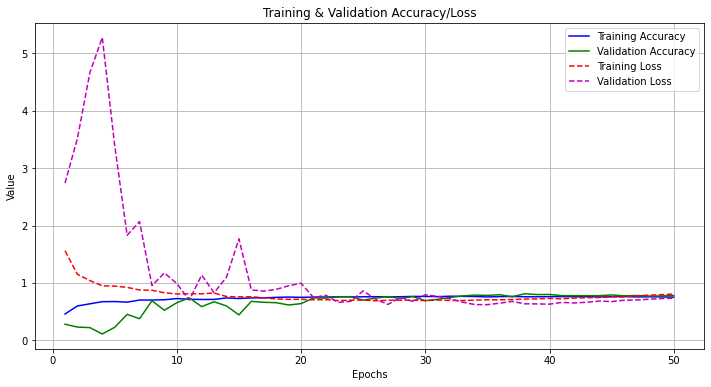

In [54]:
import matplotlib.pyplot as plt

# Extract history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

# Plot accuracy
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g-', label='Validation Accuracy')

# Plot loss
plt.plot(epochs, loss, 'r--', label='Training Loss')
plt.plot(epochs, val_loss, 'm--', label='Validation Loss')

plt.title('Training & Validation Accuracy/Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# -------------------------
# Load Best Model for Evaluation
# -------------------------

best_model = tf.keras.models.load_model("best_model.h5")

test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=1)
print(f"Best Model Test Accuracy: {test_acc:.4f}")

# Predict
y_pred_probs = best_model.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report + Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
print(confusion_matrix(y_test, y_pred))

6/6 [==============================] - 2s 276ms/step - loss: 0.6051 - accuracy: 0.8278
Best Model Test Accuracy: 0.8278
6/6 [==============================] - 2s 280ms/step
                         precision    recall  f1-score   support

                Healthy       1.00      1.00      1.00        20
  Mild_Bacterial_blight       0.89      0.80      0.84        20
             Mild_Blast       0.67      0.50      0.57        20
         Mild_Brownspot       0.89      0.85      0.87        20
            Mild_Tungro       0.94      0.80      0.86        20
Severe_Bacterial_blight       0.77      0.85      0.81        20
           Severe_Blast       0.75      0.75      0.75        20
       Severe_Brownspot       0.76      0.95      0.84        20
          Severe_Tungro       0.79      0.95      0.86        20

               accuracy                           0.83       180
              macro avg       0.83      0.83      0.82       180
           weighted avg       0.83      0.83 

y_test size: 180
y_pred size: 180


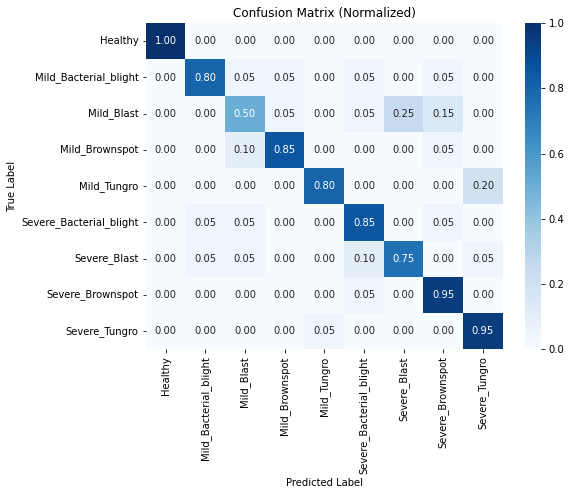

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Make sure arrays are not empty
print("y_test size:", len(y_test))
print("y_pred size:", len(y_pred))

# Build confusion matrix with explicit number of classes
num_classes = len(class_names)
cm = confusion_matrix(y_test, y_pred, labels=range(num_classes))

# Normalize safely
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)  # replace NaNs with 0

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Normalized)")
plt.show()

In [57]:
def get_img_array(img, size=(128, 128)):
    img = tf.image.resize(img, size)
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    return img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create model to map the last conv layer to output
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Record operations for gradient calculation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)

    # Mean intensity of the gradients for each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by its gradient importance
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize to 0–1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(original_img, heatmap, alpha=0.4):
    # Convert to 0–255 range for display
    original_img = np.array(original_img)
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the image
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.image.resize(
        np.expand_dims(jet_heatmap, 0),
        (original_img.shape[0], original_img.shape[1])
    ).numpy()[0]

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + original_img
    superimposed_img = np.uint8(255 * superimposed_img / np.max(superimposed_img))

    return superimposed_img

# Choose the last convolutional layer in your ConvNeXt model
last_conv_layer_name = None
for layer in reversed(ConvNeXt_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break
if last_conv_layer_name is None:
    raise ValueError("No Conv2D layer found in model.")

print("Last conv layer for Grad-CAM:", last_conv_layer_name)

Last conv layer for Grad-CAM: conv2d_86


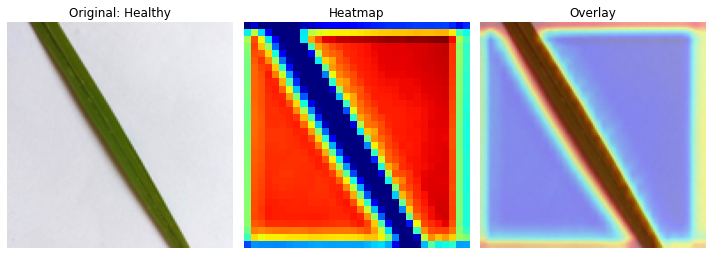

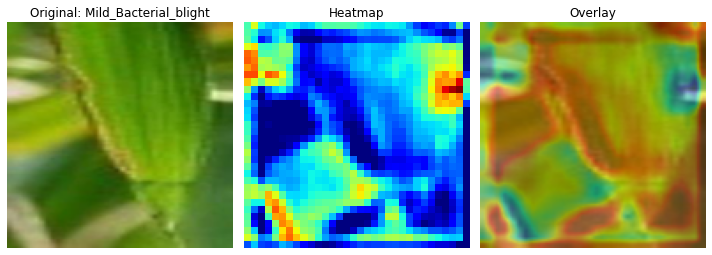

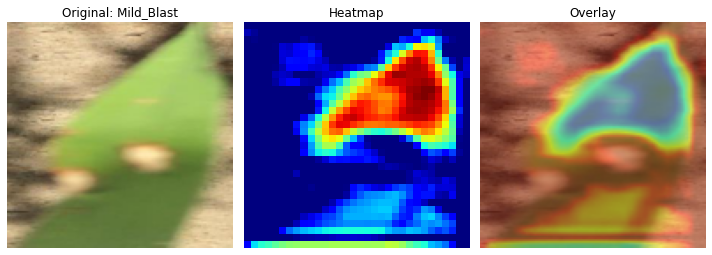

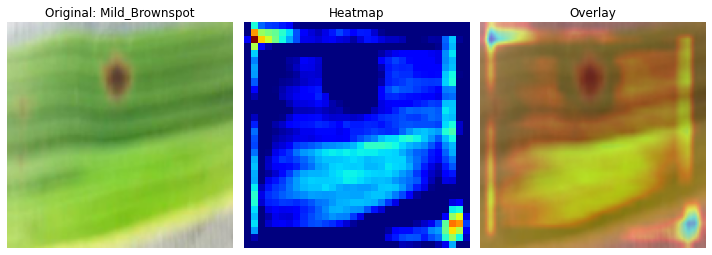

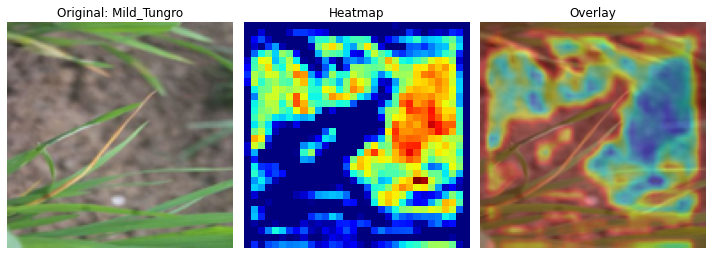

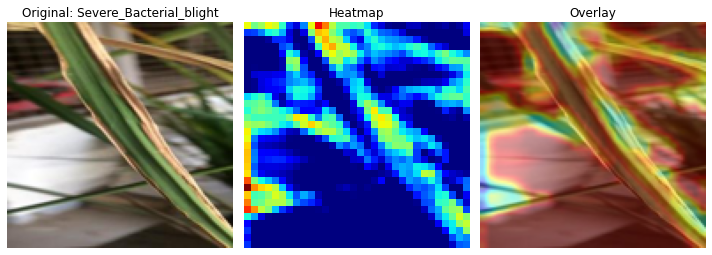

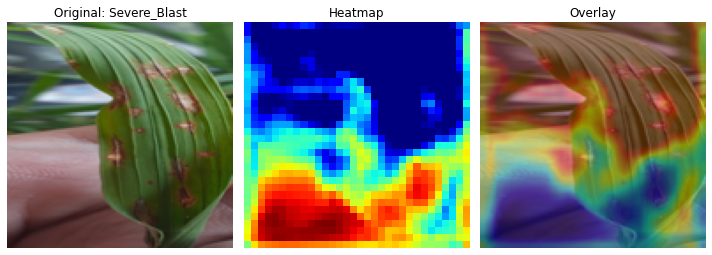

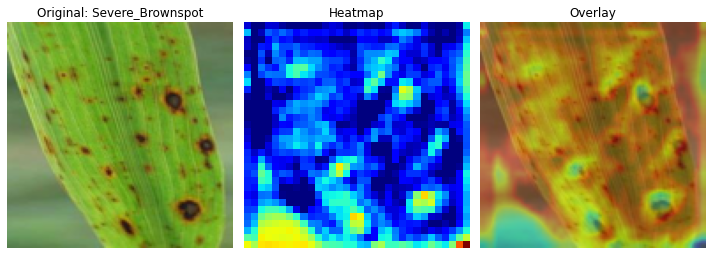

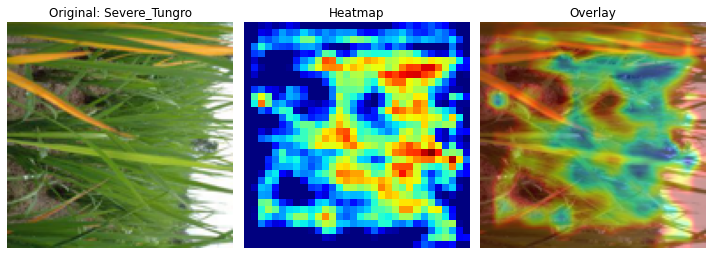

In [58]:
# -------------------------
# Grad-CAM Heatmaps
# -------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    import cv2
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img.astype("uint8"), 1-alpha, heatmap, alpha, 0)
    return overlay

# Pick last conv layer name automatically
last_conv_layer_name = [l.name for l in best_model.layers if isinstance(l, layers.Conv2D)][-1]

# Use x_test / y_test for Grad-CAM
for class_idx, class_name in enumerate(class_names):
    indices = np.where(y_test == class_idx)[0]
    if len(indices) == 0:
        print(f"No samples found for class {class_name}, skipping...")
        continue
    
    idx = indices[0]
    img_array = x_test[idx] * 255.0  # scale back to 0–255 for visualization
    input_array = np.expand_dims(x_test[idx], axis=0)  # model expects normalized input (0–1)

    # Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(input_array, best_model, last_conv_layer_name, pred_index=class_idx)
    overlay = display_gradcam(img_array, heatmap)

    # Plot results
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    ax[0].imshow(img_array.astype("uint8"))
    ax[0].set_title(f"Original: {class_name}")
    ax[0].axis("off")

    ax[1].imshow(heatmap, cmap="jet")
    ax[1].set_title("Heatmap")
    ax[1].axis("off")

    ax[2].imshow(overlay)
    ax[2].set_title("Overlay")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

# References

* https://arxiv.org/abs/2201.03545

* https://github.com/facebookresearch/ConvNeXt

* https://arxiv.org/abs/1512.03385

* https://arxiv.org/abs/2103.14030

* https://arxiv.org/abs/1607.06450

* https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec

* https://paperswithcode.com/method/inverted-residual-block

* https://github.com/keras-team/keras/blob/master/keras/applications/convnext.py

* https://paperswithcode.com/method/gelu


# Citation
```bibtex
@Article{liu2022convnet,
  author  = {Zhuang Liu and Hanzi Mao and Chao-Yuan Wu and Christoph Feichtenhofer and Trevor Darrell and Saining Xie},
  title   = {A ConvNet for the 2020s},
  journal = {Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)},
  year    = {2022},
}
```